In [32]:
CONFIG_PATH = "configs/subreddit_minority_no_peer.yml"
print(CONFIG_PATH)
from utils import get_config, join_sets, load_model, print_log, save_model, load_model_dict
config = get_config(CONFIG_PATH, "_curation", print_config = False)
active_user_votes_thres = config["active_user_votes_thres"]
batch_size = config["batch_size"]

configs/subreddit_minority_no_peer.yml
GPU ready...
Smart using cuda:1


In [33]:
from collections import Counter, defaultdict
import os
import random
import shutil
import numpy as np
import pandas as pd
from superdebug import debug
import torch
from process_data import get_model_input
from model import get_best_model
from matplotlib import pyplot as plt
from venn import venn, pseudovenn
from utils import get_user_reps, get_bool_vec, record_existing_votes
import time
import re
submission_sentiment_map = {}
submission_class_map = {}
submission_entity_map = {}

##### Preprocess

Load model and data

In [34]:
target, original_feature_map, categorical_features, string_features, train_data, test_data, test_data_info, train_submission_upvote_df, num_all_users = get_model_input(config)
extra_input = (categorical_features, string_features, target)
model, token_embedding = get_best_model(config, categorical_features, string_features, original_feature_map)
model.eval()
all_users = list(range(max(max(train_data["USERNAME"]), max(test_data["USERNAME"])) + 1))

------------------ 2022-08-23 23:18:30 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/process_data.py:363 get_model_input
Loading prepared data...
------------------ 2022-08-23 23:18:30 ------------------
------------------ 2022-08-23 23:18:35 ------------------
DEBUG: 1 vars: ['original_token_num'], at /home/TableSense/largedisk/wanrong/Curation-Modeling/model.py:248 get_tokenizer
0 / 33.  original_token_num num val: 30522
------------------ 2022-08-23 23:18:35 ------------------
------------------ 2022-08-23 23:18:35 ------------------
DEBUG: 1 vars: ['latest_token_num'], at /home/TableSense/largedisk/wanrong/Curation-Modeling/model.py:260 get_tokenizer
0 / 34.  latest_token_num num val: 219887
------------------ 2022-08-23 23:18:35 ------------------


Some weights of the model checkpoint at prajjwal1/bert-mini were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


------------------ 2022-08-23 23:18:37 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:113 load_model
Loading best model...
------------------ 2022-08-23 23:18:37 ------------------


Collect submissions and active users in different subreddits

In [35]:
def get_subreddits_submissions(train_data:pd.DataFrame, test_data:pd.DataFrame, user_votes_thres = 0, max_test_submissions_per_subreddit = 9999999999999):
    subreddit_votes_counter = Counter()
    subreddit_user_vote_count = defaultdict(Counter)
    subreddit_train_submissions = defaultdict(dict)
    subreddit_test_submissions = defaultdict(dict)
    all_submissions = {}
    for i, row in train_data.iterrows():
        subreddit_votes_counter[row["SUBREDDIT"]] += 1
        subreddit_user_vote_count[row["SUBREDDIT"]][f'{row["USERNAME"]}-{int(row["VOTE"])}'] += 1
        if row["SUBMISSION_ID"] not in subreddit_train_submissions[row["SUBREDDIT"]]:
            subreddit_train_submissions[row["SUBREDDIT"]][row["SUBMISSION_ID"]] = row
            all_submissions[row["SUBMISSION_ID"]] = row
    subreddit_active_users = defaultdict(set)
    for subreddit in subreddit_user_vote_count:
        users_vote_count = subreddit_user_vote_count[subreddit]
        subreddit_active_users[subreddit] = {int(user_vote[:-2]) for user_vote in users_vote_count if users_vote_count[f"{user_vote[:-2]}-1"] + users_vote_count[f"{user_vote[:-2]}-0"] >= user_votes_thres}
    test_data = test_data.sample(frac = 1)
    for i, row in test_data.iterrows():
        if row["SUBMISSION_ID"] not in subreddit_test_submissions[row["SUBREDDIT"]] and len(subreddit_test_submissions[row["SUBREDDIT"]]) < max_test_submissions_per_subreddit:
            subreddit_test_submissions[row["SUBREDDIT"]][row["SUBMISSION_ID"]] = row
            all_submissions[row["SUBMISSION_ID"]] = row
    return subreddit_votes_counter, subreddit_active_users, subreddit_user_vote_count, subreddit_train_submissions, subreddit_test_submissions, all_submissions

subreddit_votes_counter, subreddit_active_users, subreddit_user_vote_count, subreddit_train_submissions, subreddit_test_submissions, all_submissions = get_subreddits_submissions(train_data, test_data, user_votes_thres = active_user_votes_thres, max_test_submissions_per_subreddit=config["max_test_submissions_per_subreddit"]) # subreddit_votes_counter, subreddit_users, subreddit_train_submissions are based on train_data, subreddit_test_submissions are based on test_data
# print(sorted([(subreddit, len(subreddit_active_users[subreddit])) for subreddit in subreddit_active_users], key = lambda x: x[1], reverse = True))

Record down existing votes

So that we can use them to substitute the predicted votes

In [36]:
existing_votes, existing_user_votes, existing_user_updown_votes, existing_submission_votes, existing_user_subreddits = record_existing_votes(train_data)

#### Predict votes for all the users on all submissions

Define required functions

In [37]:
from typing import Union
# from tqdm import tqdm
from tqdm.notebook import tqdm
from train import evaluate_model
from model import get_tokenizer

def convert_group_users_subreddit_submissions_data(group_users:Union[set,list], unique_submissions:dict):
    group_users_submissions_data = []
    if type(unique_submissions) == dict:
        unique_submissions = pd.DataFrame(list(unique_submissions.values()))

    for user in tqdm(group_users):
        # for submission_id in unique_submissions:
        #     submission:pd.DataFrame = unique_submissions[submission_id].copy(deep=True)
        #     submission["USERNAME"] = user
        #     group_users_submissions_data.append(submission)
        submissions = unique_submissions.copy(deep=True)
        submissions["USERNAME"] = [user] * len(submissions) # it doesn't matter whether the user itself is in UPVOTED_USERS / DOWNVOTED_USERS: we will substitute it with real votes
        group_users_submissions_data.append(submissions)

    group_users_submissions_data = pd.concat(group_users_submissions_data,axis=0)
    return group_users_submissions_data
def predict_group_users_submissions_votes(config, model, group_users_submissions_data, extra_input):
    # predict unseen votes
    return evaluate_model(config, model, data=group_users_submissions_data, weights = None, batch_size=config["batch_size"], sample_voted_users=False, extra_input = extra_input, ret = "prediction") # ndarray size: (3423664, 1)
pred_all_user_submission_vote_score_matrix = None

# model.device = "cuda:0"
def get_group_user_submission_vote_score_matrix(predicted_group_users_submissions_votes:np.ndarray, group_users, group_users_submissions_data:pd.DataFrame, existing_votes, existing_pred_user_submission_vote_score_matrix = None, upvote_confidence_thres = 0):
    all_sub_ids = group_users_submissions_data["SUBMISSION_ID"].unique()
    if existing_pred_user_submission_vote_score_matrix is not None:
        pred_user_submission_vote_score_matrix = existing_pred_user_submission_vote_score_matrix
    else:
        pred_user_submission_vote_score_matrix = pd.DataFrame(- np.ones([max(group_users) + 1, len(all_sub_ids)], dtype = float), columns=all_sub_ids)
    pred_user_submission_vote_matrix = pd.DataFrame(- np.ones([max(group_users) + 1, len(all_sub_ids)], dtype = int), columns=all_sub_ids) # use ground truth vote if available, -1 for not in data
    each_submission_votes = {}
    each_user_confidence = defaultdict(list)
    submission_ids = group_users_submissions_data["SUBMISSION_ID"].to_numpy()
    usernames = group_users_submissions_data["USERNAME"].to_numpy()
    for row_i in tqdm(range(len(group_users_submissions_data))):
        submission_id = submission_ids[row_i]
        username = usernames[row_i]
        if existing_pred_user_submission_vote_score_matrix is not None:
            vote_score = existing_pred_user_submission_vote_score_matrix.at[username, submission_id]
            vote_score = float(vote_score)
            assert vote_score != -1, f"BUG: submission_id: {submission_id}, username: {username}, vote_score: {vote_score}"
        else:
            vote_score = predicted_group_users_submissions_votes[row_i, 0]
            pred_user_submission_vote_score_matrix.loc[username, submission_id] = vote_score
        if f'{username}-{submission_id}' not in existing_votes:
            vote = int(vote_score >= (0.5 + upvote_confidence_thres))
        else: # use existing votes if available
            vote = int(existing_votes[f'{username}-{submission_id}'] >= 0.5)
            
        if submission_id not in each_submission_votes:
            each_submission_votes[submission_id] = [0, 0]
        each_user_confidence[username].append(abs(vote_score - 0.5))
        pred_user_submission_vote_matrix.at[username, submission_id] = vote
        each_submission_votes[submission_id][vote] += 1
    assert (pred_user_submission_vote_matrix.to_numpy() != -1).sum() > 0
    
    # analyze user confidence
    for username in each_user_confidence:
        each_user_confidence[username] = float(np.mean(each_user_confidence[username]))
        
    # calculate %upvotes for each submission
    for submission_id in each_submission_votes:
        each_submission_votes[submission_id].append(each_submission_votes[submission_id][1] / (each_submission_votes[submission_id][0] + each_submission_votes[submission_id][1])) # %upvotes
    return each_submission_votes, each_user_confidence, pred_user_submission_vote_score_matrix, pred_user_submission_vote_matrix
def get_group_users_preferred_submissions(each_submission_votes:dict, upvote_ratio_thres = 0.5):
    # sort submissions using %upvotes
    group_submissions_ranking = list(each_submission_votes.keys())
    group_submissions_ranking.sort(reverse=True, key=lambda id: each_submission_votes[id][-1])
    
    # include submissions to preferred_submissions where %upvotes is higher than threshold
    group_preferred_submissions = set()
    for submission_id in group_submissions_ranking:
        if each_submission_votes[submission_id][-1] >= upvote_ratio_thres:
            group_preferred_submissions.add(submission_id)
    
    return group_preferred_submissions, group_submissions_ranking

def get_group_users_real_vote(group_users:Union[set,list], unique_submissions:dict, existing_votes, metric = "upvote_rate"):
    all_sub_ids = list(unique_submissions.keys())
    debug(group_users)
    pred_user_submission_vote_score_matrix = pd.DataFrame(- np.ones([max(group_users) + 1, len(all_sub_ids)], dtype = float), columns=all_sub_ids)
    pred_user_submission_vote_matrix = pd.DataFrame(- np.ones([max(group_users) + 1, len(all_sub_ids)], dtype = int), columns=all_sub_ids)
    each_submission_votes = {}
    for submission_id in unique_submissions:
        each_submission_votes[submission_id] = [0, 0]
    for username in group_users:
        for submission_id in unique_submissions:
            if f'{username}-{submission_id}' in existing_votes:
                vote = int(existing_votes[f'{username}-{submission_id}'] >= 0.5)
                pred_user_submission_vote_matrix.at[username, submission_id] = vote
                pred_user_submission_vote_score_matrix[username, submission_id] = vote
                each_submission_votes[submission_id][vote] += 1
                
    each_user_confidence = {user: [0.5] for user in group_users}
    
    # calculate %upvotes for each submission
    for submission_id in each_submission_votes:
        if metric == "upvote_rate":
            if each_submission_votes[submission_id][0] + each_submission_votes[submission_id][1] == 0:
                metric_res = -1
            else:
                metric_res = each_submission_votes[submission_id][1] / (each_submission_votes[submission_id][0] + each_submission_votes[submission_id][1])
        elif metric == "#upvote-#downvote":
            metric_res = each_submission_votes[submission_id][1] - each_submission_votes[submission_id][0]
        each_submission_votes[submission_id].append(metric_res)
        
    
    return each_submission_votes, each_user_confidence, pred_user_submission_vote_score_matrix, pred_user_submission_vote_matrix

Convert data to model input, then run model to make predictions, and obtain prediction score matrix and vote matrix. Note that we use actual votes to replace predicted votes when available.

_!!! This process can be time consuming & need more than 200G memory for medium sized dataset, and is not necessary if we use user_embedding to cluster active users_

In [38]:
if config["user_grouping_method"] == "predict_all_submissions":
    # Convert data to model input
    # TODO: not all users
    all_users_submissions_data = convert_group_users_subreddit_submissions_data(all_users, all_submissions)

    # run model to make predictions
    model.to(model.device)
    predicted_all_users_submissions_votes = predict_group_users_submissions_votes(config, model, all_users_submissions_data, extra_input)
    debug(predicted_all_users_submissions_votes=predicted_all_users_submissions_votes)

    import pickle
    pickle.dump(predicted_all_users_submissions_votes, open("output/predicted_all_users_submissions_votes.pt", "wb"))
    # predicted_all_users_submissions_votes = pickle.load(open("output/predicted_all_users_submissions_votes.pt", "rb"))

    # Obtain prediction score matrix and vote matrix. We use actual votes to replace predicted votes when available
    all_submission_votes, all_users_confidence, pred_all_user_submission_vote_score_matrix, pred_all_user_submission_vote_matrix = get_group_user_submission_vote_score_matrix(predicted_all_users_submissions_votes, all_users, all_users_submissions_data, existing_votes)
    
    # all_users_preferred_submissions, all_preferred_submissions_ranking = get_group_users_preferred_submissions(all_submission_votes, upvote_ratio_thres = config["upvote_ratio_thres"])

Calculate Pearson correlation between users

In [39]:
if config["user_grouping_method"] == "predict_all_submissions":
    debug((pred_all_user_submission_vote_matrix==-1).any())
    debug(pred_all_user_submission_vote_score_matrix=pred_all_user_submission_vote_score_matrix, pred_all_user_submission_vote_matrix=pred_all_user_submission_vote_matrix)
    vote_score_pearson_corr = np.corrcoef(pred_all_user_submission_vote_score_matrix) # (697, 697)
    debug(vote_score_pearson_corr=vote_score_pearson_corr)

#### Perform curation on a subreddit

Select a subreddit from the most popular subreddits

In [40]:
selected_subreddit = None
selected_subreddit = config["selected_subreddit"]
selected_subreddit = "r/politics" # r/politics_r/Conservative_r/Liberal_r/Republican_r/democrats_r/VoteBlue
# selected_subreddit = "r/politics r/Conservative r/Liberal r/Republican r/democrats r/VoteBlue r/Feminism r/MensRights"

In [41]:
def get_selected_subreddit_info(config, selected_subreddit, subreddit_active_users, subreddit_votes_counter, subreddit_train_submissions, subreddit_test_submissions, original_feature_map, active_user_votes_thres):
    if selected_subreddit is None:
        common_subreddits_counts = subreddit_votes_counter.most_common(100)
        prompt = []
        for subreddit_id, vote_counts in common_subreddits_counts:
            if " " in subreddit_id: continue
            subreddit_name_str = (original_feature_map['SUBREDDIT'][subreddit_id] + ', ') if 'SUBREDDIT' in original_feature_map else ''
            prompt.append(f"{subreddit_id}: {subreddit_name_str}{vote_counts} votes;")
        prompt = "\n".join(prompt)
        selected_subreddit = input(f"{prompt}\nSelect subreddits: ")
    multi_subreddits = selected_subreddit.split(" ")
    if len(multi_subreddits) == 1:
        multi_subreddits = selected_subreddit.split("_")
    if "interest" in multi_subreddits:
        multi_subreddits.remove("interest")
    for sub in multi_subreddits:
        if 'SUBREDDIT' in original_feature_map:
            sub = int(sub)
            subreddit_name_str = (f" ({original_feature_map['SUBREDDIT'][sub]})")
        else:
            subreddit_name_str =  ''
        print_log(config["log_path"], f"Selected subreddit: {sub}{subreddit_name_str}")
        print_log(config["log_path"], f"In train data, subreddit {sub} have {len(subreddit_active_users[sub])} active users (who votes >= {active_user_votes_thres} times), {subreddit_votes_counter[sub]} votes and {len(subreddit_train_submissions[sub])} unique submissions. In test data, subreddit {sub} have {len(subreddit_test_submissions[sub])} unique submissions.") 
        
        if len(multi_subreddits) > 1: # when we are using more than one subreddits
            assert sub in subreddit_active_users
            subreddit_active_users[selected_subreddit].update(subreddit_active_users[sub])
            subreddit_votes_counter[selected_subreddit] += subreddit_votes_counter[sub]
            subreddit_train_submissions[selected_subreddit].update(subreddit_train_submissions[sub])
            subreddit_test_submissions[selected_subreddit].update(subreddit_test_submissions[sub])
            
    selected_subreddit_active_users:set = subreddit_active_users[selected_subreddit]
    print_log(config["log_path"], f"In train data, subreddit {selected_subreddit} have {len(selected_subreddit_active_users)} active users (who votes >= {active_user_votes_thres} times), {subreddit_votes_counter[selected_subreddit]} votes and {len(subreddit_train_submissions[selected_subreddit])} unique submissions. In test data, subreddit {selected_subreddit} have {len(subreddit_test_submissions[selected_subreddit])} unique submissions.") 
    return selected_subreddit_active_users, subreddit_active_users, subreddit_votes_counter, subreddit_train_submissions, subreddit_test_submissions

selected_subreddit_active_users, subreddit_active_users, subreddit_votes_counter, subreddit_train_submissions, subreddit_test_submissions = get_selected_subreddit_info(config, selected_subreddit, subreddit_active_users, subreddit_votes_counter, subreddit_train_submissions, subreddit_test_submissions, original_feature_map, active_user_votes_thres)

------------------ 2022-08-23 23:22:59 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:126 print_log
Selected subreddit: r/politics
------------------ 2022-08-23 23:22:59 ------------------
------------------ 2022-08-23 23:22:59 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:126 print_log
In train data, subreddit r/politics have 9708 active users (who votes >= 5 times), 865017 votes and 201823 unique submissions. In test data, subreddit r/politics have 500 unique submissions.
------------------ 2022-08-23 23:22:59 ------------------
------------------ 2022-08-23 23:22:59 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:126 print_log
In train data, subreddit r/politics have 9708 active users (who votes >= 5 times), 865017 votes and 201823 unique submissions. In test data, subreddit r/politics have 500 unique submissions.
------------------ 2022-08-23 23:22:59 

Analyze submissions content

In [42]:
# analyze_post = config["analyze_post"]
analyze_post = False

In [43]:
def get_submissions_text(submission_ids, subreddit_test_submissions, selected_subreddit, pass_analyzed = False, submission_sentiment_map = None, submission_class_map = None, submission_entity_map = None):
    _submission_ids = []
    submissions_text = []
    for submission_id in submission_ids:
        # if "SUBMISSION_ID" in original_feature_map:
        #     submission_id = original_feature_map["SUBMISSION_ID"][submission_id]
        # submissions_text.append(submission_text_map[submission_id])
        if pass_analyzed:
            if submission_id in submission_sentiment_map and submission_id in submission_class_map and submission_id in submission_entity_map:
                continue
        _submission_ids.append(submission_id)
        submissions_text.append(subreddit_test_submissions[selected_subreddit][submission_id]["SUBMISSION_TEXT"])
    if pass_analyzed:
        return _submission_ids, submissions_text
    else:
        return submissions_text

if analyze_post and config["submission_source"] == "test_data":
    import os
    import json
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "google-service-account-file.json"
    from google.cloud import language_v1
    from sqlalchemy import create_engine, Column, Integer, String
    from sqlalchemy.orm import sessionmaker
    from sqlalchemy.ext.declarative import declarative_base
    import grpc, google
    client = language_v1.LanguageServiceClient()
    
    submission_analysis_path = "data/reddit/submission_analysis.db"
    engine = create_engine(f"sqlite:///{submission_analysis_path}", connect_args={'timeout': 10})
    DBSession = sessionmaker(bind=engine)
    session = DBSession()

    Base = declarative_base()
    
    class Analysis(Base):
        __tablename__ = 'analysis'
        id = Column(String, primary_key=True, autoincrement=True)
        sentiment_score = Column(Integer)
        content_classes = Column(String)
        entities = Column(String)

In [44]:
def post_analysis(content, language_v1, client, google):
    document = language_v1.Document(content=content.lower(), type_=language_v1.Document.Type.PLAIN_TEXT)
    try:
        sentiment_score = client.analyze_sentiment(document=document).document_sentiment.score
    except google.api_core.exceptions.InvalidArgument: #grpc.RpcError:
        sentiment_score = None
    except google.api_core.exceptions.TooManyRequests:
        sentiment_score = None
    except google.api_core.exceptions.ResourceExhausted:
        sentiment_score = None
    except google.api_core.exceptions.InternalServerError:
        sentiment_score = None
    try:
        content_classes = [cls.name for cls in client.classify_text(document=document).categories]
    except google.api_core.exceptions.InvalidArgument: #grpc.RpcError:
        content_classes = []
    except google.api_core.exceptions.TooManyRequests:
        content_classes = []
    except google.api_core.exceptions.ResourceExhausted:
        content_classes = []
    except google.api_core.exceptions.InternalServerError:
        content_classes = []
    try:
        entities = [ent.name for ent in client.analyze_entities(document=document).entities]
    except google.api_core.exceptions.InvalidArgument: #grpc.RpcError:
        entities = []
    except google.api_core.exceptions.TooManyRequests:
        entities = []
    except google.api_core.exceptions.ResourceExhausted:
        entities = []
    except google.api_core.exceptions.InternalServerError:
        entities = []
        
    return (sentiment_score, content_classes, entities)

def post_analysis_batch(id_content_map:dict, session, Analysis, submission_sentiment_map, submission_class_map, submission_entity_map, language_v1, client, google):
    ids = list(id_content_map.keys())
    existing_items = []
    for i in tqdm(range(len(ids) // 1000 + 1)):
        existing_items.extend(session.query(Analysis).filter(Analysis.id.in_(ids[1000*i:1000*(i+1)])).all())
    for item in existing_items:
        if item.sentiment_score == -9999 and item.content_classes == "[]" and item.entities == "[]":
            session.query(Analysis).filter(Analysis.id == item.id).delete()
            continue
        submission_sentiment_map[item.id] = item.sentiment_score if item.sentiment_score != -9999 else None
        submission_class_map[item.id] = json.loads(item.content_classes)
        submission_entity_map[item.id] = json.loads(item.entities)
        del id_content_map[item.id]
    session.commit()
    id_remain = list(id_content_map.keys())
    for sub_i, id in enumerate(tqdm(id_remain)):
        sentiment_score, content_classes, entities = post_analysis(id_content_map[id], language_v1, client, google)
        submission_sentiment_map[id] = sentiment_score
        submission_class_map[id] = content_classes
        submission_entity_map[id] = entities
        session.add(Analysis(id=id, sentiment_score = sentiment_score if sentiment_score is not None else -9999, content_classes=json.dumps(content_classes), entities=json.dumps(entities)))
        session.commit()    

if analyze_post and config["submission_source"] == "test_data":
    # submission_text_map = test_data[["SUBMISSION_ID", "SUBMISSION_TEXT"]].drop_duplicates("SUBMISSION_ID").set_index("SUBMISSION_ID").to_dict()['SUBMISSION_TEXT']

    subreddit_submissions_ids = list(subreddit_test_submissions[selected_subreddit].keys())
    subreddit_submissions_ids, subreddit_submissions_text = get_submissions_text(subreddit_submissions_ids, subreddit_test_submissions, selected_subreddit, pass_analyzed = True, submission_sentiment_map = submission_sentiment_map, submission_class_map = submission_class_map, submission_entity_map = submission_entity_map)
    submission_ids, pass_analyzed = False, 
    # subreddit_submissions_ids, subreddit_submissions_text
    post_analysis_batch({id: text for id, text in zip(subreddit_submissions_ids, subreddit_submissions_text)}, session, Analysis, submission_sentiment_map, submission_class_map, submission_entity_map, language_v1, client, google)

##### Obtain representations for active users

User representation will be used to cluster users into groups if `user_grouping_method` is `neural` or `vote`

In [45]:
user_grouping_method = config["user_grouping_method"] # 
user_grouping_method = "interest_r/Conservative_r/Liberal_r/Republican_r/democrats_r/VoteBlue random_user_as_group none"
# user_grouping_method = "interest_r/Feminism_r/MensRights" #TODO: change this
# user_grouping_method = "interest_r/Conservative_r/Liberal_r/Republican_r/democrats_r/VoteBlue" #TODO: change this

manual_user_groups = config["manual_user_groups"]
# manual_user_groups = {"Conservative": {66, 39, 10, 44, 16, 60}, "Democratic":{0, 65, 64, 37, 49, 52, 20, 22, 23, 26, 29}}
debug(user_grouping_method=user_grouping_method)


------------------ 2022-08-23 23:23:00 ------------------
DEBUG: 1 vars: ['user_grouping_method'], at <ipython-input-45-8e2ef889333e>:8 <module>
0 / 35.  user_grouping_method str len 95: interest_r/Conservative_r/Liberal_r/Republican_r/democrats_r/VoteBlue random_user_as_group none
------------------ 2022-08-23 23:23:00 ------------------


Either use this one... (clustering using vote prediction score on submissions in this subreddit, make sure `pred_all_user_submission_vote_score_matrix` is available)

In [46]:
if pred_all_user_submission_vote_score_matrix is not None:
    debug(pred_all_user_submission_vote_score_matrix=pred_all_user_submission_vote_score_matrix)
    subreddit_submissions_bool_vec = get_bool_vec(subreddit_test_submissions[selected_subreddit].keys(), pred_all_user_submission_vote_score_matrix.shape[1])
    selected_subreddit_active_users_reps, selected_subreddit_active_user_i_user_map = get_user_reps(selected_subreddit_active_users, all_user_embedding=pred_all_user_submission_vote_score_matrix[:, subreddit_submissions_bool_vec], train_data=train_data, selected_submissions = subreddit_train_submissions[selected_subreddit], method = user_grouping_method)

Or this one... (cluster using user_embedding or sparse actual votes)

In [47]:
if pred_all_user_submission_vote_score_matrix is None:
    debug(max_user = max(all_users), max_selected_subreddit_active_users = max([int(_) for _ in selected_subreddit_active_users]))
    all_username_tokens = [f"USERNAME_{user_i}" for user_i in all_users]
    all_username_token_ids = torch.tensor(model.tokenizer.convert_tokens_to_ids(all_username_tokens))
    all_username_token_ids = all_username_token_ids.to(model.device); model = model.to(model.device)
    with torch.no_grad():
        user_embedding = model.lm_encoder.embeddings.word_embeddings(all_username_token_ids)
        debug(user_embedding=user_embedding.shape)
    # debug(all_username_tokens=all_username_tokens, all_username_token_ids=all_username_token_ids, user_embedding=user_embedding)
    selected_subreddit_active_users_reps, selected_subreddit_active_user_i_user_map = get_user_reps(selected_subreddit_active_users, all_user_embedding=user_embedding, train_data=train_data, selected_submissions = subreddit_train_submissions[selected_subreddit], user_grouping_method = user_grouping_method)
    debug(selected_subreddit_active_users_reps=selected_subreddit_active_users_reps) # NOTE: selected_subreddit_active_users_reps is not None only if user_grouping_method == "neural" or "votes"

------------------ 2022-08-23 23:23:01 ------------------
DEBUG: 2 vars: ['max_user', 'max_selected_subreddit_active_users'], at <ipython-input-47-02c58a0ba750>:2 <module>
0 / 36.  max_user num val: 183781
1 / 37.  max_selected_subreddit_active_users num val: 183757
------------------ 2022-08-23 23:23:01 ------------------
------------------ 2022-08-23 23:23:01 ------------------
DEBUG: 1 vars: ['user_embedding'], at <ipython-input-47-02c58a0ba750>:8 <module>
0 / 38.  user_embedding torch.Size with val:  torch.Size([183782, 256])
------------------ 2022-08-23 23:23:01 ------------------
------------------ 2022-08-23 23:23:02 ------------------
DEBUG: 1 vars: ['selected_subreddit_active_users_reps'], at <ipython-input-47-02c58a0ba750>:11 <module>
0 / 39.  selected_subreddit_active_users_reps None
------------------ 2022-08-23 23:23:02 ------------------


##### Obtain the users' political affiliations and the bias of media

In [48]:
def get_url_reliability_bias():
    reliability_bias_df = pd.read_csv("tools/scrape_adfontes_media/data/ad_fontes_media_sources_ratings__2022_01_17.csv")
    source_url_df = pd.read_csv("data/political_bias/ad fontes media statistics 11.2020-12.2020.csv")
    source_url_df["source"] = source_url_df["source"].map(lambda x: x.replace("-", ""))
    reliability_bias_df["source"] = reliability_bias_df["source"].map(lambda x: x.lower().replace(" ", ""))
    reliability_bias_df = source_url_df.merge(reliability_bias_df, on = "source", how = "left")
    reliability_bias_df["reliability"] = reliability_bias_df.apply(lambda row: row["reliability"] if pd.notna(row["reliability"]) else row["_reliability"], axis = 1)
    reliability_bias_df["bias"] = reliability_bias_df.apply(lambda row: row["bias"] if pd.notna(row["bias"]) else row["_bias"], axis = 1)
    reliability_bias_df = reliability_bias_df[["source", "reliability", "bias", "url"]]
    reliability_bias_df.set_index("url", inplace = True)
    print(reliability_bias_df) # .iloc[:2]

    media_url_re = "("+"|".join(reliability_bias_df.index.to_list())+")"
    media_url_re = media_url_re.replace(".", "\.")
    return reliability_bias_df, media_url_re

def get_political_bias(submission_text, reliability_bias_df, media_url_re):
    bias = []
    urls = re.findall(media_url_re, submission_text)
    for url in urls:
        if url in reliability_bias_df.index:
            bias.append(reliability_bias_df.loc[url]["bias"])
    if bias:
        return np.mean(bias)
    else:
        return np.nan
    
if "interest" in user_grouping_method or "political_affiliation" in user_grouping_method:
    reliability_bias_df, media_url_re = get_url_reliability_bias()



                              source  reliability   bias
url                                                     
abcnews.go.com               abcnews        46.64  -4.66
aljazeera.com              aljazeera        45.54  -4.44
alternet.org                alternet        23.28 -19.34
americanthinker.com  americanthinker        18.41  25.36
apnews.com                        ap        49.05  -2.03
...                              ...          ...    ...
washingtontimes.com  washingtontimes        31.86  14.89
wonkette.com                wonkette        17.28 -26.75
worldtruth.tv           worldtruthtv         7.41   8.48
wnd.com                          wnd        22.33  20.57
zerohedge.com              zerohedge        25.60  14.82

[120 rows x 3 columns]


##### Cluster active users into multiple groups

In [49]:
from reddit import get_user_info


def get_user_groups(selected_subreddit, selected_users, selected_users_reps, selected_user_i_user_map:dict, user_grouping_method = "neural", existing_user_votes=None, manual_user_groups=None, train_data=None, original_feature_map=None, selected_submissions=None, model=None, subreddit_active_users=None, selected_subreddit_active_users=None, subreddit_user_vote_count = None, reliability_bias_df=None, media_url_re=None, extra_input=None):
    group_centers = None
    users_in_groups = defaultdict(set)
    if "upvote_downvote" in user_grouping_method:
        selected_submissions = list(selected_submissions.values())
        while True:
            some_submission_data = random.choice(selected_submissions)
            use_submission = input("Use this submission?: "+some_submission_data["SUBMISSION_TEXT"])
            if len(use_submission) > 0:
                break
        some_submission_data = pd.DataFrame([some_submission_data] * len(selected_users))
        some_submission_data["USERNAME"] = selected_users
        predicted_some_submission_users_votes = predict_group_users_submissions_votes(config, model, some_submission_data, extra_input)
        for row_i, user in enumerate(selected_users):
            if predicted_some_submission_users_votes[row_i] >= 0.5:
                users_in_groups["upvote"].add(user)
            else:
                users_in_groups["downvote"].add(user)
        assert len(users_in_groups["upvote"]) > 0 and len(users_in_groups["downvote"]) > 0
    
    if "interest" in user_grouping_method:
        interest_subreddits = [_ for _ in user_grouping_method.split(" ") if "interest" in _][0].split("_")
        interest_subreddits.remove("interest")
        interest_subreddit_active_users = {}
        debug(f"Using the intersection of users active in {selected_subreddit} and users actively upvote (%upvote >= 0.7) in interest_subreddit as curators")
        for interest_subreddit in interest_subreddits:
            if interest_subreddit not in subreddit_active_users: continue
            interest_subreddit_active_users[interest_subreddit] = subreddit_active_users[interest_subreddit] & selected_subreddit_active_users
            # debug(interest_subreddit, interest_subreddit_active_users[interest_subreddit])
            interest_subreddit_active_users[interest_subreddit] = {user for user in interest_subreddit_active_users[interest_subreddit] if (subreddit_user_vote_count[interest_subreddit][f"{user}-1"]/(subreddit_user_vote_count[interest_subreddit][f"{user}-1"] + subreddit_user_vote_count[interest_subreddit][f"{user}-0"]) >= 0.7)} # NOTE: upvote users subreddit_user_vote_count
        users_in_groups = {}
        for interest_subreddit in interest_subreddits:
            if interest_subreddit not in subreddit_active_users: continue
            other_subreddit_active_users = set()
            for other_subreddit in interest_subreddits:
                if other_subreddit != interest_subreddit:
                    other_subreddit_active_users.update(interest_subreddit_active_users[other_subreddit])
            users_in_groups[interest_subreddit] = interest_subreddit_active_users[interest_subreddit] - other_subreddit_active_users
            
    if "political_affiliation" in user_grouping_method:
        user_bias = defaultdict(list)
        train_bias = train_data["SUBMISSION_TEXT"].map(lambda x: get_political_bias(x, reliability_bias_df, media_url_re)).to_numpy()
        all_usernames = train_data["USERNAME"].to_list()
        for row_i, username in enumerate(all_usernames):
            if not np.isnan(train_bias[row_i]):
                user_bias[username].append(train_bias[row_i])
        for username in user_bias:
            user_bias[username] = np.mean(user_bias[username])
            if user_bias[username] < -15:
                users_in_groups["left"].add(username)
            elif user_bias[username] > 15:
                users_in_groups["right"].add(username)
        
    if "manual" in user_grouping_method:
        if manual_user_groups is not None:
            users_in_groups.update(manual_user_groups)
        else:
            user_preferences = defaultdict(dict)
            usernames = train_data["USERNAME"].to_list()
            votes = train_data["VOTE"].to_list()
            submissions_text = train_data["SUBMISSION_TEXT"].to_list()
            for row_i, username in enumerate(usernames):
                vote = votes[row_i]
                submission_text = submissions_text[row_i]
                if vote not in user_preferences[username]:
                    user_preferences[username][vote] = []
                user_preferences[username][vote].append(submission_text)
            all_users = list(user_preferences.keys())
            user_info_list = []
            for _ in range(20):
                possible_user = random.choice(all_users)
                user_info, user_info_str = get_user_info(possible_user)
                user_info["username"] = possible_user
                user_info["joined subreddits"] = existing_user_subreddits[possible_user]
                user_info_list.append(user_info)
            user_info_df = pd.DataFrame.from_records(user_info_list).set_index("username")
            print(user_info_df)
            users_in_groups["manual"] = set([original_feature_map["USERNAME"][username] for username in input("Enter usernames: ").split(" ")])
            
    if "neural" in user_grouping_method or "votes" in user_grouping_method:
        n_groups = int(len(selected_user_i_user_map) / 5) # TODO: change how many users in a group
        debug(num_selected_users = len(selected_user_i_user_map), n_groups=n_groups) # n_groups: 118
        debug("Begin grouping...")
        from sklearn.cluster import KMeans
        grouping = KMeans(n_clusters = n_groups, random_state = 42, verbose = 0).fit(selected_users_reps)
        group_centers = grouping.cluster_centers_
        """
        from sklearn.cluster import AgglomerativeClustering
        grouping = AgglomerativeClustering(linkage = "complete").fit(selected_users_reps)
        """
        """
        from sklearn.cluster import SpectralClustering
        grouping = SpectralClustering(n_groups, random_state = 42, verbose = 0).fit(selected_users_reps)
        """
        labels = grouping.labels_ # grouping.labels_: [584 350 948 ... 813 938 152]
        """
        from sklearn.mixture import GaussianMixture
        labels = GaussianMixture(n_groups, random_state = 42, verbose = 0).fit_predict(selected_users_reps)
        """
        usernames_in_groups = defaultdict(set)
        for user_i, group_x in enumerate(labels): 
            users_in_groups[group_x].add(selected_user_i_user_map[user_i])
            usernames_in_groups[group_x].add(original_feature_map["USERNAME"][selected_user_i_user_map[user_i]])
        debug(group_user_num=str({group_x: len(users_in_groups[group_x]) for group_x in users_in_groups}))
        debug(usernames_in_groups=str(usernames_in_groups))
        
    if  "single_user_as_group" in user_grouping_method or  "all_user_as_group" in user_grouping_method or "random_user_as_group" in user_grouping_method:
        assert existing_user_votes is not None
        all_users = list(selected_user_i_user_map.values())
        all_users.sort(key=lambda x:existing_user_votes[x])
        if "single_user_as_group" in user_grouping_method:
            all_users = all_users[:10] + all_users[-10:]
            for i, user in enumerate(all_users):
                users_in_groups[i] = {user}
            # users_in_groups = {i: {user} for i,user in selected_user_i_user_map.items()}
        if "all_user_as_group" in user_grouping_method:
            users_in_groups["all_users"] = all_users
        if "random_user_as_group" in user_grouping_method:
            users_in_groups["random_users"] = random.sample(all_users, 50)
    
    if "none" in user_grouping_method: # none: using broadcast
        users_in_groups["none"] = []
            
    return users_in_groups, group_centers


if type(selected_subreddit_active_users_reps) == torch.tensor: selected_subreddit_active_users_reps = selected_subreddit_active_users_reps.cpu()
users_in_groups, group_centers = get_user_groups(selected_subreddit, selected_subreddit_active_users, selected_subreddit_active_users_reps, selected_subreddit_active_user_i_user_map, user_grouping_method=user_grouping_method, existing_user_votes=existing_user_votes, manual_user_groups=manual_user_groups, train_data = train_data, original_feature_map=original_feature_map, selected_submissions = subreddit_train_submissions[selected_subreddit], model = model, subreddit_active_users=subreddit_active_users, selected_subreddit_active_users=selected_subreddit_active_users, subreddit_user_vote_count = subreddit_user_vote_count, reliability_bias_df=reliability_bias_df, media_url_re=media_url_re, extra_input=extra_input)
debug(user_num_in_group = {x: len(y) for x, y in users_in_groups.items()})



UnboundLocalError: local variable 'interest_subreddit' referenced before assignment

##### Predict preferred submissions of each group

Select submissions to curate. Test submissions in this Subreddit or customized submission

In [ ]:
if config["submission_source"] == "test_data":
    submissions_before_curation:dict = subreddit_test_submissions[selected_subreddit]
elif config["submission_source"] == "custom":
    custom_submission_id = "custom_" + str(random.randint(1000000000000000, 9999999999999999))
    custom_username = input("Input author's username: ") # TODO:
    custom_title = input("Input post title: ") # 'Employee of the year' 'This is so funny!!!'
    custom_content = input("Input post content: ")
    custom_submission = pd.Series({
        'SUBMISSION_ID': custom_submission_id,
        'SUBREDDIT': selected_subreddit,
        'CREATED_TIME': re.sub("[0-9][0-9]:[0-9][0-9]:[0-9][0-9] ", "", time.ctime(time.time())),
        'USERNAME': 9271, # TODO:
        'VOTE': 1.0,
        'TITLE': custom_title,
        'AUTHOR': custom_username,
        '#_COMMENTS': 0,
        'NSFW': 'false',
        'SCORE': 0,
        'UPVOTED_%': 0.5,
        'LINK': '',
        'SUBMISSION_TEXT': (custom_title + " [SEP] " + custom_content) if custom_content != "" else custom_title,
        'UPVOTED_USERS': [], # TODO:
        'DOWNVOTED_USERS': []}
    )
    submissions_before_curation = {custom_submission_id: custom_submission}
    print(submissions_before_curation)
    
pred_group_votes_info = {}

⭐️ Set parameters

In [ ]:
batch_size = 1024
upvote_ratio_thres = 0.5 # TODO: # config["upvote_ratio_thres"]
upvote_confidence_thres = 0.0 # config["upvote_confidence_thres"] # TODO:

Predict and show their relationship using venn.

------------------ 2022-08-23 22:40:48 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:126 print_log
Predicting group r/Conservative with 255 users
------------------ 2022-08-23 22:40:48 ------------------


  0%|          | 0/255 [00:00<?, ?it/s]

100%|██████████| 1993/1993 [00:48<00:00, 40.87it/s]


  0%|          | 0/127500 [00:00<?, ?it/s]

------------------ 2022-08-23 22:41:58 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:126 print_log
Users in group r/Conservative prefers 1/500 submissions (%upvotes ≥ 0.5)
------------------ 2022-08-23 22:41:58 ------------------
------------------ 2022-08-23 22:41:58 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:126 print_log
Predicting group r/Liberal with 28 users
------------------ 2022-08-23 22:41:58 ------------------


  0%|          | 0/28 [00:00<?, ?it/s]

100%|██████████| 219/219 [00:05<00:00, 40.36it/s]


  0%|          | 0/14000 [00:00<?, ?it/s]

------------------ 2022-08-23 22:42:07 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:126 print_log
Users in group r/Liberal prefers 397/500 submissions (%upvotes ≥ 0.5)
------------------ 2022-08-23 22:42:07 ------------------


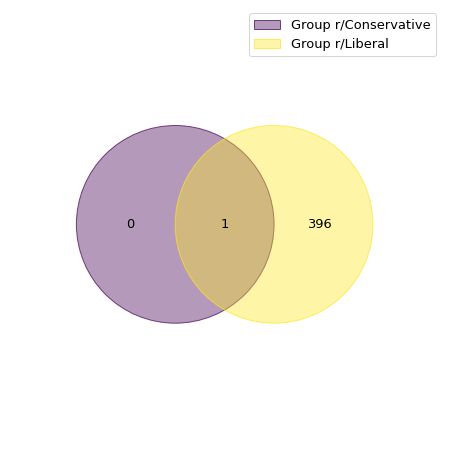

------------------ 2022-08-23 22:42:07 ------------------
DEBUG: at <ipython-input-21-f24e37449c22>:76 predict_groups_preferences
Figure saved in output/figures/preferred_subs/2_groups.png
------------------ 2022-08-23 22:42:07 ------------------
------------------ 2022-08-23 22:42:07 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:126 print_log
Predicting group r/Republican with 8 users
------------------ 2022-08-23 22:42:07 ------------------


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 63/63 [00:01<00:00, 39.80it/s]


  0%|          | 0/4000 [00:00<?, ?it/s]

------------------ 2022-08-23 22:42:11 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:126 print_log
Users in group r/Republican prefers 78/500 submissions (%upvotes ≥ 0.5)
------------------ 2022-08-23 22:42:11 ------------------


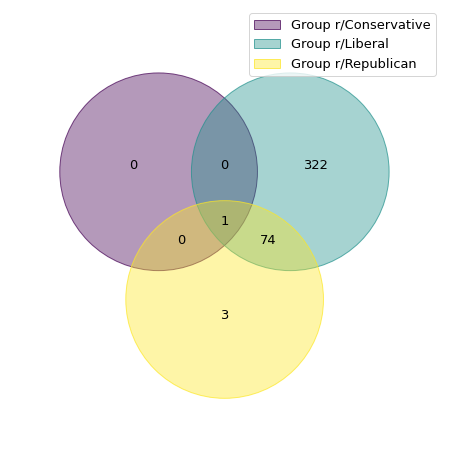

------------------ 2022-08-23 22:42:11 ------------------
DEBUG: at <ipython-input-21-f24e37449c22>:76 predict_groups_preferences
Figure saved in output/figures/preferred_subs/3_groups.png
------------------ 2022-08-23 22:42:11 ------------------
------------------ 2022-08-23 22:42:11 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:126 print_log
Predicting group r/democrats with 88 users
------------------ 2022-08-23 22:42:11 ------------------


  0%|          | 0/88 [00:00<?, ?it/s]

100%|██████████| 688/688 [00:16<00:00, 40.55it/s]


  0%|          | 0/44000 [00:00<?, ?it/s]

------------------ 2022-08-23 22:42:36 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:126 print_log
Users in group r/democrats prefers 394/500 submissions (%upvotes ≥ 0.5)
------------------ 2022-08-23 22:42:36 ------------------


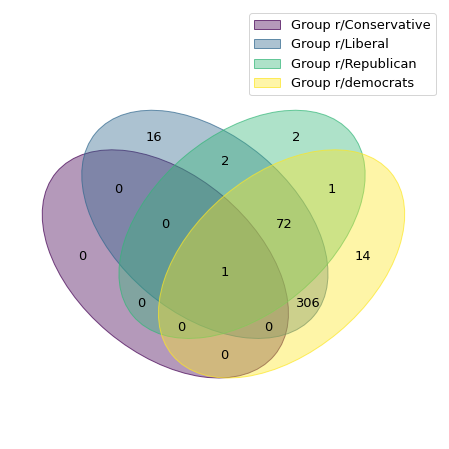

------------------ 2022-08-23 22:42:36 ------------------
DEBUG: at <ipython-input-21-f24e37449c22>:76 predict_groups_preferences
Figure saved in output/figures/preferred_subs/4_groups.png
------------------ 2022-08-23 22:42:36 ------------------
------------------ 2022-08-23 22:42:36 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:126 print_log
Predicting group r/VoteBlue with 157 users
------------------ 2022-08-23 22:42:36 ------------------


  0%|          | 0/157 [00:00<?, ?it/s]

100%|██████████| 1227/1227 [00:29<00:00, 40.94it/s]


  0%|          | 0/78500 [00:00<?, ?it/s]

------------------ 2022-08-23 22:43:20 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:126 print_log
Users in group r/VoteBlue prefers 367/500 submissions (%upvotes ≥ 0.5)
------------------ 2022-08-23 22:43:20 ------------------


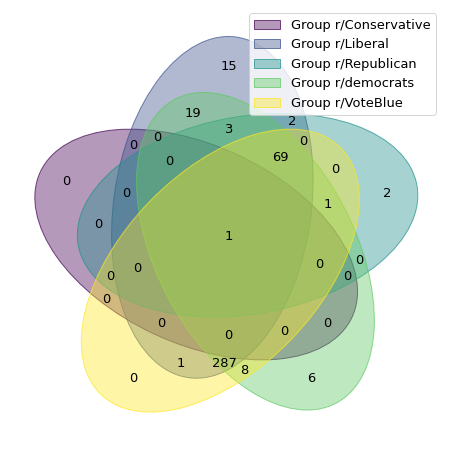

------------------ 2022-08-23 22:43:20 ------------------
DEBUG: at <ipython-input-21-f24e37449c22>:76 predict_groups_preferences
Figure saved in output/figures/preferred_subs/5_groups.png
------------------ 2022-08-23 22:43:20 ------------------
------------------ 2022-08-23 22:43:20 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:126 print_log
Predicting group random_users with 50 users
------------------ 2022-08-23 22:43:20 ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 391/391 [00:09<00:00, 42.06it/s]


  0%|          | 0/25000 [00:00<?, ?it/s]

------------------ 2022-08-23 22:43:35 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:126 print_log
Users in group random_users prefers 362/500 submissions (%upvotes ≥ 0.5)
------------------ 2022-08-23 22:43:35 ------------------


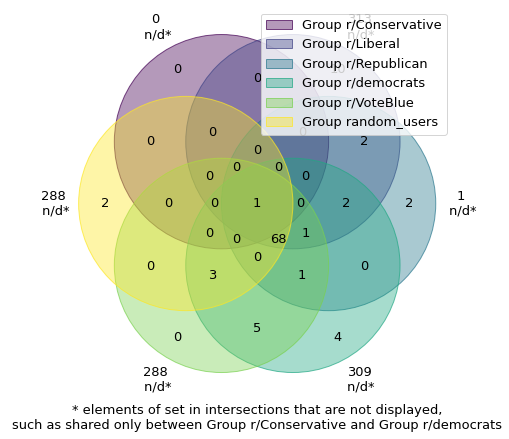

------------------ 2022-08-23 22:43:35 ------------------
DEBUG: at <ipython-input-21-f24e37449c22>:76 predict_groups_preferences
Figure saved in output/figures/preferred_subs/6_groups.png
------------------ 2022-08-23 22:43:35 ------------------


In [ ]:
def predict_groups_preferences(config, model, users_in_groups, unique_submissions:dict, subreddit_test_submissions, selected_subreddit, upvote_ratio_thres = 0.5, group_centers=None, user_grouping_method = "rep", existing_votes = None, existing_user_updown_votes = None, pred_group_votes_info = None, upvote_confidence_thres = 0, selected_subreddit_active_user_i_user_map=None, extra_input = None):
    # users_in_groups = existing_user_votes.most_common(3)
    groups_preferred_submissions = {}
    groups_preferred_submissions_text = {}
    # groups_submission_upvote_count_matrix = np.zeros([len(users_in_groups), len(unique_submissions)])
    groups_submission_upvote_count_matrix = pd.DataFrame(np.zeros([len(users_in_groups), len(unique_submissions)]), index = list(users_in_groups.keys())) 
    unique_submissions_ids = list(unique_submissions.keys())
    used_group_centers = []
    if os.path.exists(config["preferred_submissions_venn_figure_dir"]):
        shutil.rmtree(config["preferred_submissions_venn_figure_dir"])
    os.makedirs(config["preferred_submissions_venn_figure_dir"], exist_ok=True)
    for group_x in users_in_groups:
        if ((not ("political_affiliation" in user_grouping_method)) and (not ("interest" in user_grouping_method)) and (not ("upvote_downvote" in user_grouping_method))) and (((not ("single_user_as_group" in user_grouping_method and len(users_in_groups[group_x]) == 1)) and (not ("none" in user_grouping_method and len(users_in_groups[group_x]) == 0)) and len(users_in_groups[group_x]) <= config["group_user_num_lower_thres"]) or ("all_user_as_group" not in user_grouping_method and len(users_in_groups[group_x]) > config["group_user_num_upper_thres"])): # keep middle sized centers
            continue
        if len(users_in_groups[group_x]) == 0:
            continue
        if group_centers is not None: # only keep not similar centers
            group_x_center = group_centers[group_x]
            similar_center = False
            for center in used_group_centers:
                if np.dot(group_x_center, center) > 0:
                    similar_center = True
                    break
            if similar_center:
                # continue
                print_log(config["log_path"], "Have similar center with existing group")
            used_group_centers.append(group_x_center)

        ################ predicting votes of some users and some submissions ##################
        print_log(config["log_path"], f"Predicting group {group_x} with {len(users_in_groups[group_x])} users") #  :{users_in_groups[group_x]}
        
        if len(users_in_groups[group_x]) > 0:
            group_x_subreddit_submissions_data = convert_group_users_subreddit_submissions_data(users_in_groups[group_x], unique_submissions)
            if group_x not in pred_group_votes_info or group_x == "manual":
                predicted_group_x_submissions_votes = predict_group_users_submissions_votes(config, model, group_x_subreddit_submissions_data, extra_input)
                group_x_submission_votes, group_x_confidence, pred_group_x_subreddit_submission_vote_score_matrix, pred_group_x_subreddit_submission_vote_matrix = get_group_user_submission_vote_score_matrix(predicted_group_x_submissions_votes, users_in_groups[group_x], group_x_subreddit_submissions_data, existing_votes, upvote_confidence_thres=upvote_confidence_thres)
                
                pred_group_votes_info[group_x] = pred_group_x_subreddit_submission_vote_score_matrix
            else:
                debug("Using existing pred_group_votes_info")
                pred_group_x_subreddit_submission_vote_score_matrix = pred_group_votes_info[group_x]
                group_x_submission_votes, group_x_confidence, pred_group_x_subreddit_submission_vote_score_matrix, pred_group_x_subreddit_submission_vote_matrix = get_group_user_submission_vote_score_matrix(None, users_in_groups[group_x], group_x_subreddit_submissions_data, existing_votes, existing_pred_user_submission_vote_score_matrix=pred_group_x_subreddit_submission_vote_score_matrix, upvote_confidence_thres=upvote_confidence_thres)
        elif len(users_in_groups[group_x]) == 0: # no user in this group, i.e., without curation, just count real votes
            group_x_submission_votes, group_x_confidence, pred_group_x_subreddit_submission_vote_score_matrix, pred_group_x_subreddit_submission_vote_matrix = get_group_users_real_vote(list(selected_subreddit_active_user_i_user_map.values()), unique_submissions, existing_votes, metric = "upvote_rate")
        
        group_x_preferred_submissions, group_x_preferred_submissions_ranking = get_group_users_preferred_submissions(group_x_submission_votes, upvote_ratio_thres = upvote_ratio_thres)
    
        pred_group_x_subreddit_submission_vote_matrix_np = pred_group_x_subreddit_submission_vote_matrix[unique_submissions_ids].to_numpy()
        pred_group_x_subreddit_submission_vote_matrix_np = pred_group_x_subreddit_submission_vote_matrix_np[pred_group_x_subreddit_submission_vote_matrix_np.sum(axis=1) >= 0]
        groups_submission_upvote_count_matrix.loc[group_x] = pred_group_x_subreddit_submission_vote_matrix_np.sum(axis=0).astype(float)/len(pred_group_x_subreddit_submission_vote_matrix_np)
        

        ################# Display submissions preferred by each group of users ######################

        if "single_user_as_group" in user_grouping_method:
            user_train_vote_prompt = f"voted {existing_user_updown_votes[list(users_in_groups[group_x])[0]]} in training data, prediction confidence {list(group_x_confidence.values())[0]}, "
        else:
            user_train_vote_prompt = ""
            
        group_x_preferred_ranked_submissions = group_x_preferred_submissions_ranking[:len(group_x_preferred_submissions)]
        groups_preferred_submissions[group_x] = group_x_preferred_ranked_submissions # group_x_preferred_submissions
        
        # convert submission text content
        group_x_preferred_ranked_submissions_text = get_submissions_text(group_x_preferred_ranked_submissions, subreddit_test_submissions, selected_subreddit)
        groups_preferred_submissions_text[group_x] = group_x_preferred_ranked_submissions_text
            
        print_log(config["log_path"], f"Users in group {group_x} {user_train_vote_prompt}prefers {len(group_x_preferred_submissions)}/{len(unique_submissions)} submissions (%upvotes ≥ {upvote_ratio_thres})") #  (sorted using %upvotes): {group_x_preferred_ranked_submissions}, with text {group_x_preferred_ranked_submissions_text}

        # draw venn diagram            
        if len(groups_preferred_submissions) > 1 and len(groups_preferred_submissions) <=6 and sum([len(_) for _ in groups_preferred_submissions.values()]) > 0:
            venn_input = {x: set(x) for x in groups_preferred_submissions}
            ax = venn(venn_input) if len(groups_preferred_submissions) <=5 else pseudovenn(venn_input)
            plt.show()
            figure_path = f"{config['preferred_submissions_venn_figure_dir']}/{len(groups_preferred_submissions)}_groups.png"
            ax.figure.savefig(figure_path)
            debug(f"Figure saved in {figure_path}")
    return groups_preferred_submissions, groups_preferred_submissions_text, groups_submission_upvote_count_matrix

model = model.to(model.device); model.eval()
groups_preferred_submissions, groups_preferred_submissions_text, groups_submission_upvote_count_matrix = predict_groups_preferences(config, model, users_in_groups, submissions_before_curation, subreddit_test_submissions, selected_subreddit, group_centers=group_centers, user_grouping_method=user_grouping_method, existing_votes=existing_votes, existing_user_updown_votes=existing_user_updown_votes, pred_group_votes_info = pred_group_votes_info, upvote_ratio_thres = upvote_ratio_thres, upvote_confidence_thres=upvote_confidence_thres, selected_subreddit_active_user_i_user_map=selected_subreddit_active_user_i_user_map, extra_input=extra_input)

Show posting prompt

In [ ]:
if config["submission_source"] == "custom":
    debug(groups_submission_upvote_count_matrix)
    print(f"You can post immediately in {[group_x for group_x in groups_preferred_submissions if len(groups_preferred_submissions[group_x]) > 0]}. You will need to wait for more votes to post in {[group_x for group_x in groups_preferred_submissions if len(groups_preferred_submissions[group_x]) == 0]} -- your post will stay in the background first. Currently, ", end = "")
    for group_x in groups_preferred_submissions:
        group_x_int = int(group_x.split(" ")[-1])
        print(f"{100 * groups_submission_upvote_count_matrix[group_x_int, 0]}% of the curators in {group_x} are predicted to upvote on your post; ", end = "")

Show preferred different posts 

In [ ]:
max_show_posts = 30
if len(groups_preferred_submissions_text) > 0:
    all_preferred_submissions_text = set.intersection(*[set(groups_preferred_submissions_text[group_x]) for group_x in groups_preferred_submissions_text])
    # groups_preferred_submissions_text

    for group_x in groups_preferred_submissions_text:
        print(f"Users in group {group_x} prefers {[_ for _ in groups_preferred_submissions_text[group_x] if _ in set(groups_preferred_submissions_text[group_x]) - all_preferred_submissions_text][:max_show_posts]}") # 
else:
    debug("groups_preferred_submissions_text is empty")


Users in group Group r/Conservative prefers []
Users in group Group r/Liberal prefers ["'We need to care for working people as much as we care for the stock market': Alexandria Ocasio-Cortez and Bernie Sanders blasted the Fed's $1.5 trillion injection", "'Outrageous': Sanders Condemns Kentucky GOP for Threatening to Overturn Gubernatorial Election", 'Bernie Sanders rides enthusiasm to top showing in latest Iowa Poll', 'Trump Livid After California Allows Statewide Mail-In Voting: ‘These Votes Must Not Count’', 'House Speaker Pelosi says may look at guaranteed income, other aid', 'Americans of All Stripes Want a Mail Ballot Option - As the president wages a disinformation campaign against mail voting, nearly 80 percent of Americans want a mail ballot option this November', "Dick Van Dyke Hams It Up At Bernie Sanders Rally, Crowd Chants 'We Love Dick'", 'How Pence meddled in foreign aid, rerouting money to favored Christian groups', 'Leaked documents show Facebook leveraged user data to 

##### Calculate Pearson correlation of different groups

In [ ]:
print("Pearson ranking items:", groups_submission_upvote_count_matrix.index.to_list())
groups_submission_upvote_count_matrix_nonzero = groups_submission_upvote_count_matrix[groups_submission_upvote_count_matrix.sum(axis = 1) != 0]
group_preference_pearson_corr = np.corrcoef(groups_submission_upvote_count_matrix_nonzero) # (697, 697)
debug(group_preference_pearson_corr)

Pearson ranking items: ['r/Conservative', 'r/Liberal', 'r/Republican', 'r/democrats', 'r/VoteBlue', 'random_users', 6]
------------------ 2022-08-23 22:43:36 ------------------
DEBUG: 1 vars: ['?'], at <ipython-input-24-0f8c7dde1ff3>:4 <module>
0 / 29.  ? ndarray size: (6, 6) val: [[1.         0.36623683 0.63853372 0.27593154 0.24572275 0.3655347 ]
 [0.36623683 1.         0.455975   0.91859494 0.90652697 0.920464  ]
 [0.63853372 0.455975   1.         0.38483533 0.34336027 0.45521977]
 [0.27593154 0.91859494 0.38483533 1.         0.97532337 0.92327383]
 [0.24572275 0.90652697 0.34336027 0.97532337 1.         0.92410645]
 [0.3655347  0.920464   0.45521977 0.92327383 0.92410645 1.        ]]
------------------ 2022-08-23 22:43:36 ------------------


Group r/Conservative: average bias 0, all subreddits Counter({'r/politics': 1}), average sentiment 0.0000, all classes {}, all words Counter({'court': 6, 'supreme': 4, 'records': 4, 'president': 3, 'trump': 3, 'tax': 3, 'arguments': 2, 'presidential': 2, 'immunity': 2, 'hearing': 2, 'whether': 2, 'returns': 2, 'financial': 2, 'congressional': 2, 'committees': 2, 'three': 2, 'cases': 2, 'listen': 2, 'business': 2, 'live': 2, 'discussion': 1, 'thread': 1, 'scotus': 1, 'hears': 1, 'today': 1, 'absolute': 1, 'legislative': 1, 'oversight': 1, 'tuesday': 1, 'began': 1, 'considering': 1, 'shield': 1, 'income': 1, 'disclosure': 1, 'keep': 1, 'private': 1, 'new': 1, 'york': 1, 'prosecutor': 1, 'landmark': 1, 'constitutional': 1, 'conference': 1, 'call': 1, 'novel': 1, 'coronavirus': 1, 'pandemic': 1, 'making': 1, 'possible': 1, 'public': 1, 'justices': 1, 'questions': 1, 'real': 1, 'time': 1, 'listener': 1, 'guide': 1, 'battle': 1, 'involve': 1, 'effort': 1, 'prevent': 1, 'longtime': 1, 'accoun

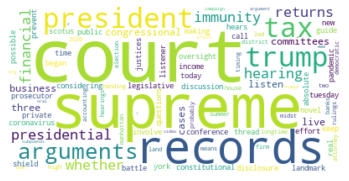

Group r/Liberal: average bias -2.6250000000000004, all subreddits Counter({'r/politics': 397}), average sentiment 0.0000, all classes {}


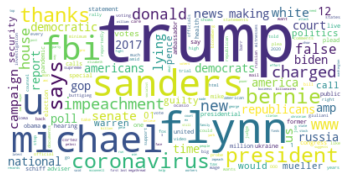

Group r/Republican: average bias 0, all subreddits Counter({'r/politics': 78}), average sentiment 0.0000, all classes {}


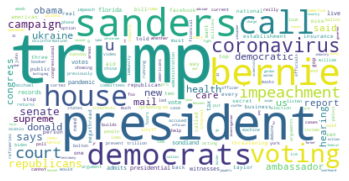

Group r/democrats: average bias -4.870000000000001, all subreddits Counter({'r/politics': 394}), average sentiment 0.0000, all classes {}


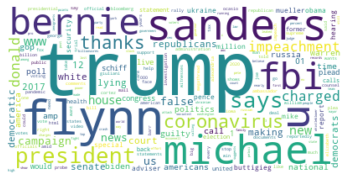

Group r/VoteBlue: average bias -4.870000000000001, all subreddits Counter({'r/politics': 367}), average sentiment 0.0000, all classes {}


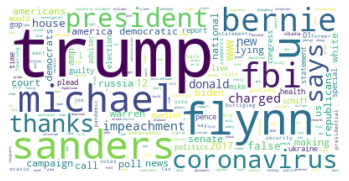

Group random_users: average bias -4.870000000000001, all subreddits Counter({'r/politics': 362}), average sentiment 0.0000, all classes {}


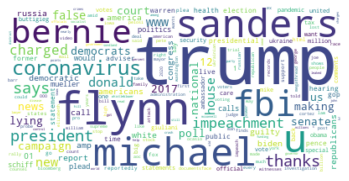

In [50]:
import seaborn as sns
import streamlit as st
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer

def visualize_group_preferences(groups_preferred_submissions, test_data, user_grouping_method, submission_sentiment_map = None, submission_class_map=None, submission_entity_map=None, reliability_bias_df = None, media_url_re = None):
    stop = set(stopwords.words('english'))
    stop.update({"deleted", "SEP", "sep", "http", "https", "com", "r"})
    tokenizer = RegexpTokenizer(r'\w+')

    submission_text_map = test_data[["SUBMISSION_ID", "SUBMISSION_TEXT"]].set_index("SUBMISSION_ID").to_dict()["SUBMISSION_TEXT"]
    if "interest" in user_grouping_method or "political_affiliation" in user_grouping_method:
        test_data["SUBMISSION_BIAS"] = test_data["SUBMISSION_TEXT"].map(lambda x: get_political_bias(x, reliability_bias_df, media_url_re)).to_numpy()
        submission_bias_map = test_data[["SUBMISSION_ID", "SUBMISSION_BIAS"]].set_index("SUBMISSION_ID").to_dict()["SUBMISSION_BIAS"]
        submission_subreddit_map = test_data[["SUBMISSION_ID", "SUBREDDIT"]].set_index("SUBMISSION_ID").to_dict()["SUBREDDIT"]

    all_classes = set()
    groups_bias = {}
    group_subreddit = {}
    groups_class_counter_rate = {}
    groups_sentiment = {}
    groups_words = {}
    for group_x in groups_preferred_submissions:
        submission_sentiments = []
        submission_bias = []
        submission_subreddit = []
        submission_classes = []
        submission_words = []
        group_preferred_submissions = groups_preferred_submissions[group_x]
        for submission_id in group_preferred_submissions:
            if submission_sentiment_map is not None and submission_id in submission_sentiment_map and submission_sentiment_map[submission_id]:
                submission_sentiments.append(submission_sentiment_map[submission_id])
            if submission_class_map is not None and submission_id in submission_class_map:
                submission_classes.extend(submission_class_map[submission_id])
            if submission_entity_map is not None:
                if submission_id in submission_entity_map:
                    submission_words.extend(submission_entity_map[submission_id])
                else:
                    submission_words.extend([_ for _ in tokenizer.tokenize(submission_text_map[submission_id].lower()) if _ not in stop])
            if "interest" in user_grouping_method or "political_affiliation" in user_grouping_method:
                if not np.isnan(submission_bias_map[submission_id]):
                    submission_bias.append(submission_bias_map[submission_id])
                submission_subreddit.append(submission_subreddit_map[submission_id])
            
        
        if "interest" in user_grouping_method or "political_affiliation" in user_grouping_method:
            groups_bias[group_x] = np.mean(submission_bias) if len(submission_bias) > 0 else 0
            group_subreddit[group_x] = Counter(submission_subreddit)
        class_counter = Counter(submission_classes)
        all_classes.update(class_counter.keys())
        class_counter_rate = {k: v/len(group_preferred_submissions) for k, v in class_counter.items()}
        groups_class_counter_rate[group_x] = class_counter_rate
    
        groups_sentiment[group_x] = np.mean(submission_sentiments) if len(submission_sentiments) > 0 else 0
    
        groups_words[group_x] = submission_words
    all_classes = list(all_classes)
    for group_x in groups_class_counter_rate:
        class_counter_rate = groups_class_counter_rate[group_x]
        preference_info_str = ""
        preference_info_str += f"{group_x}: "
        if group_x in groups_bias:
            preference_info_str += f"average bias {groups_bias[group_x]}, all subreddits {group_subreddit[group_x]}, "
        preference_info_str += f"average sentiment {groups_sentiment[group_x]:.4f}, all classes {class_counter_rate}"
        submission_words_counter = Counter(groups_words[group_x])
        if len(submission_words_counter) < 100:
            preference_info_str += f", all words {submission_words_counter}\n"
        print(preference_info_str)
        st.write(preference_info_str)
    
        # visualize wordcloud
        if len(submission_words_counter) > 0:
            wordcloud = WordCloud(stopwords=stop, background_color="white").generate_from_frequencies(submission_words_counter)
            ax = plt.imshow(wordcloud, interpolation='bilinear')
            st.pyplot(ax.figure)
            plt.axis("off")
            plt.show()
            plt.close()
    
        # visualize topic distribution
        if len(class_counter_rate) > 0:
            class_counter_rate = {cls: [class_counter_rate.get(cls, 0)] for cls in all_classes}
            class_counter_rate_df = pd.DataFrame.from_dict(class_counter_rate).transpose()
            ax = sns.barplot(x=class_counter_rate_df.index, y=class_counter_rate_df[0])
            ax.set(ylim=(0, 0.2))
            st.pyplot(ax.figure)
            plt.show()
            plt.close()

visualize_group_preferences(groups_preferred_submissions, test_data, user_grouping_method, submission_sentiment_map = submission_sentiment_map, submission_class_map=submission_class_map, submission_entity_map=submission_entity_map, reliability_bias_df=reliability_bias_df, media_url_re=media_url_re)